### For the prediction of diseases as our output columns,a Deep Neural Network model was created that has 3 layers and each has 100 nodes. There has been created a list of datasets. Datasets have same input columns but the output columns differ. For hyperparameter tuning, some trials were made with the small dataset and at the end, the model was trained and tested iteratively for each disease and its corresponding dataset in the list.

In [2]:
library(h2o)
library(ggplot2)
library(ROSE)
library(caret)

DEEPNN_EPOCHS     <- 100                  # Maximum number of training epocs
DEEP_HIDDEN       <- c(100,100,100)       # Number of neurons in each layer
DEEP_STOPPING     <- 10                   # Number of times no improvement before stop
DEEP_TOLERANCE    <- 1e-3                 # Error threshold, want to see an improvement after DEEP_STOPPING round, o.w. stop.
DEEP_ACTIVATION   <- "TanhWithDropout"    # Non-linear activation function


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit https://docs.h2o.ai

----------------------------------------------------------------------



Attaching package: ‘h2o’


The following objects are masked from ‘package:stats’:

    cor, sd, var


The following objects are masked from ‘package:base’:

    &&, %*%, %in%, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc


Loaded ROSE 0.0-4


Loading required package: lattice



In [3]:
# This work is licensed under a Creative Commons
# Attribution-NonCommercial 4.0 International License.
# ************************************************
#
# Prof. Nick F Ryman-Tubb
# Dr Spencer Thomas 
# Department of Computer Science
# University of Surrey
# GUILDFORD
# Surrey GU2 7XH
# ************************************************
N_DEEP_TrainClassifier<- function(train,
                                  fieldNameOutput,
                                  hidden,
                                  stopping_rounds,
                                  stopping_tolerance,
                                  activation){

  #positionOutput<-which(names(train)==fieldNameOutput)

  #Creates the h2o training dataset
  train[fieldNameOutput] <- lapply(train[fieldNameOutput] , factor) #Output class has to be a R "factor"

  train_h2o <- as.h2o(train, destination_frame = "traindata")

  # Create validation dataset for early stopping
  splits <- h2o.splitFrame(train_h2o, 0.9, seed=100)
  nntrain  <- h2o.assign(splits[[1]], "nntrain.hex") # 90%
  nnvalid  <- h2o.assign(splits[[2]], "nnvalid.hex") # 10%

  #This lists all the input field names ignoring the fieldNameOutput
  predictors <- setdiff(names(train_h2o), fieldNameOutput)

  # Deep training neural network
  # Updated 13/5/17 - set reproducible = TRUE so that the same random numbers are used to initalise
  # 281019NRT - added validation dataset for early stopping

  deep<-h2o::h2o.deeplearning(x=predictors,
                              y=fieldNameOutput,
                              training_frame=nntrain,
                              validation_frame=nnvalid,
                              epochs=DEEPNN_EPOCHS,
                              hidden=hidden,
                              adaptive_rate=TRUE,
                              stopping_rounds=stopping_rounds, #default is 5 but changed to 10
                              #stopping_tolerance=stopping_tolerance,
                              #stopping_metric="logloss",
                              fast_mode=FALSE,
                              activation=activation,
                              #distribution='bernoulli',
                              #loss='CrossEntropy',
                              score_training_samples=0, #to use all samples for score
                              score_validation_samples=0, #to use all validation samples for score
                              #seed=3456,
                              #l1 = 1e-2,
                              #l2 = 1e-2,
                              #reproducible = TRUE,
                              variable_importances=TRUE)
  return(deep)
}
# ************************************************
# NEvaluateClassifier() :
#
# Use dataset to generate predictions from model
# Evaluate as classifier using threshold value
#
# INPUT   :   vector double     - probs        - probability of being class 1
#             Data Frame        - testing_data - Dataset to evaluate
#             double            - threshold     -cutoff (probability) for classification
#
# OUTPUT  :   List       - Named evaluation measures
#                        - Predicted class probability
#
# ************************************************
NEvaluateClassifier<-function(test_predicted,test_expected,threshold) {

  predictedClass<-ifelse(test_predicted<threshold,0,1)

  results<-NcalcConfusion(expectedClass=test_expected,
                          predictedClass=predictedClass)

  return(results)
} #endof NEvaluateClassifier()

NcalcConfusion<-function(expectedClass,predictedClass){

  confusion<-table(factor(predictedClass,levels=0:1),factor(expectedClass,levels=0:1))

  # This "converts" the above into our preferred format

  TP<-as.double(confusion[2,2])
  FN<-as.double(confusion[1,2])
  FP<-as.double(confusion[2,1])
  TN<-as.double(confusion[1,1])

  return(NcalcMeasures(TP,FN,FP,TN))

} #endof NcalcConfusion()

NcalcMeasures <- function(TP,FN,FP,TN){
  #accuracy<-round(((TP+TN)/(TP+FP+FN+TN)), digits=4) ##
  #precision<-round((TP/(TP+FP)),digits=4) #ppv
  npv    <-round((TN/(FN+TN)),digits=4) ##
  fpr     <-round((FP/(FP+TN)),digits=4)
  tpr     <-round((TP/(TP+FN)),digits=4) # recall, sensitivity
  tnr     <-round((TN/(FP+TN)),digits=4) #specificity
  #mcc     <-round( ((TP*TN)-(FP*FN))/sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)),digits=4)
  fnr     <-round((FN/(FN+TP)),digits=4) ##
  #f1      <-round(((2 * TP)/((2 * TP)+FP+FN)),digits=4) ##
  threatScore    <-round((TP/(TP+FN+FP)),digits=4) ##
  balancedacc    <-round(((tpr+tnr)/2),digits=4)
    
    retList<-list("TP"=TP,
                  "FN"=FN,
                  "TN"=TN,
                  "FP"=FP,
                  #"accuracy"=accuracy,
                  #"precision"=precision,
                  "NPV"=npv,
                  "FPR"=fpr,
                  "TPR"=tpr,
                  "TNR"=tnr,
                  #"MCC"=mcc,
                  "FNR"=fnr,
                  #"F1"=f1,
                  "threatScore"=threatScore,
                  "balancedacc"=balancedacc
    )
    return(retList)
}
# ************************************************
# NdetermineThreshold() :
#
# For the range of threholds [0,1] calculate a confusion matrix
# and classifier metrics.
# Deterime "best" threshold based on either distance or Youdan
# Plot threshold chart and ROC chart
#
# Plot the results
#
# INPUT   :   vector double  - test_predicted   - probability of being class 1
#         :   vector double  - test_expected    - dataset to evaluate
#         :   boolean        - plot             - TRUE=output charts
#         :   string         - title            - chart title
#
# OUTPUT  :   List       - Named evaluation measures from confusion matrix
#                        - Threshold at min Euclidean distance
#                        - AUC - area under the ROC curve
#                        - Predicted class probability
#
# 241019NRT - added plot flag and title for charts
# 311019NRT - added axis bound checks in abline plots
# 191020NRT - Updated to use own ROC plot & calculate AUC
# ************************************************
NdetermineThreshold<-function(test_predicted,
                              test_expected,
                              plot=TRUE,
                              title=""){
  toPlot<-data.frame()

  #Vary the threshold
  for(threshold in seq(0,1,by=0.01)){
    results<-NEvaluateClassifier(test_predicted=test_predicted,
                                  test_expected=test_expected,
                                  threshold=threshold)
    toPlot<-rbind(toPlot,data.frame(x=threshold,fpr=results$FPR,tpr=results$TPR, balancedacc=results$balancedacc, threatScore=results$threatScore, fnr=results$FNR))
  }

  # the Youden index is the vertical distance between the 45 degree line
  # and the point on the ROC curve.
  # Higher values of the Youden index are better than lower values.
  # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5082211/
  # Youdan = sensitivty + specificity -1
  #        = TPR + (1-FPR) -1

  #toPlot$youdan<-toPlot$tpr+(1-toPlot$fpr)-1

  # 121020NRT - max Youdan
  # use which.max() to return a single index to the higest value in the vector
  #maxYoudan<-toPlot$x[which.max(toPlot$youdan)]

  # Euclidean distance sqrt((1 − sensitivity)^2+ (1 − specificity)^2)
  # To the top left (i.e. perfect classifier)
  toPlot$distance<-sqrt(((1-toPlot$tpr)^2)+((toPlot$fpr)^2))

  # 121020NRT - Euclidean distance to "perfect" classifier (smallest the best)
  # use which.min() to return a single index to the lowest value in the vector
  minEuclidean<-toPlot$x[which.min(toPlot$distance)]

  # ************************************************
  # Plot threshold graph

  if (plot==TRUE){
    # Sensitivity (TPR)
    plot(toPlot$x,toPlot$tpr,
         xlim=c(0, 1), ylim=c(0, 1),
         type="l",lwd=3, col="blue",
         xlab="Threshold",
         ylab="Metrics",
         main=paste("Threshold Perfomance Classifier Model",title))

    # Plot the specificity (1-FPR)
    lines(toPlot$x,1-toPlot$fpr,type="l",col="red",lwd=3,lty=1)
      
    # plot the threat score
    lines(toPlot$x,toPlot$threatScore,type="l",col="orange",lwd=3,lty=1)
      
    # plot the miss rate
    lines(toPlot$x,toPlot$fnr,type="l",col="purple",lwd=3,lty=1)
    

    # The point where specificity and sensitivity are the same
    crosspoint<-toPlot$x[which(toPlot$tpr<(1-toPlot$fpr))[1]]

#     if (!is.na(crosspoint)){
#       if ((crosspoint<1) & (crosspoint>0))
#         abline(v=crosspoint,col="red",lty=3,lwd=2)
#     }

    # Plot the Euclidean distance to "perfect" classifier (smallest the best)
    lines(toPlot$x,toPlot$distance,type="l",col="green",lwd=2,lty=3)

    # Plot the min distance, as might be more (311019NRT check it is within range)
    if ((minEuclidean<1) & (minEuclidean>0))
      abline(v=minEuclidean,col="green",lty=3,lwd=2)

    # Youdan (Vertical distance between the 45 degree line and the point on the ROC curve )
    #lines(toPlot$x,toPlot$youdan,type="l",col="purple",lwd=2,lty=3)

    #if ((maxYoudan<1) & (maxYoudan>0))
    #  abline(v=maxYoudan,col="purple",lty=3,lwd=2)

    legend("right",c("Sensitivity","Specificity","Threat Score","Miss Rate","Euclidean Dist"),col=c("blue","red","orange","purple", "green"),lty=1:2,lwd=2)
    text(x=0,y=50, adj = c(-0.2,2),cex=1,col="black",paste("THRESHOLDS:\nEuclidean=",minEuclidean))

    # ************************************************

    # 121020NRT ROC graph
    balacc <- toPlot$balancedacc[which.min(toPlot$distance)]
    sensitivityROC<-toPlot$tpr[which.min(toPlot$distance)]
    specificityROC<-1-toPlot$fpr[which.min(toPlot$distance)]
    #auc<-auroc(score=test_predicted,bool=test_expected) # Estimate the AUC

    # Set origin point for plotting
    toPlot<-rbind(toPlot,data.frame(x=0,fpr=0,tpr=0 ,distance=0, threatScore=0, fnr=0, balancedacc=0))

    plot(1-toPlot$fpr,toPlot$tpr,type="l",lwd=3, col="black",
         main=paste("ROC:",title),
         xlab="Specificity (1-FPR)",
         ylab="Sensitivity (TPR)",
         xlim=c(1,0),
         ylim=c(0,1)
    )

    axis(1, seq(0.0,1.0,0.1))
    axis(2, seq(0.0,1.0,0.1))

    #Add crosshairs to the graph
    abline(h=sensitivityROC,col="red",lty=3,lwd=2)
    abline(v=specificityROC,col="red",lty=3,lwd=2)

    annotate<-paste("Threshold: ",round(minEuclidean,digits=4L),
                    "\nBalanced Acc.: ",round(balacc,digits=4L),
                    "\nSensitivity: ",round(sensitivityROC,digits=2L),
                    "\nSpecificity: ",round(specificityROC,digits=2L),
                    sep="")

    text(x=specificityROC, y=sensitivityROC, adj = c(-0.2,1.2),cex=1, col="red",annotate)

  } # endof if plotting

  # Select the threshold - I have choosen distance

  myThreshold<-minEuclidean      # Min Distance should be the same as analysis["threshold"]

  #Use the "best" distance threshold to evaluate classifier
  results<-NEvaluateClassifier(test_predicted=test_predicted,
                                test_expected=test_expected,
                                threshold=myThreshold)

  results$threshold<-myThreshold
  #results$AUC<-auroc(score=test_predicted,bool=test_expected) # Estimate the AUC
  View(results)
  return(results)

} #endof myPerformancePlot()

In [4]:
newDataset <- read.csv(file = 'brfssCleaned.csv')
head(newDataset)

,SEXVAR,GENHLTH,PHYSHLTH,MENTHLTH,HLTHPLN1,PERSDOC2,MEDCOST,CHECKUP1,EXERANY2,SLEPTIM1,⋯,ECIGARET,QSTVER,QSTLANG,METSTAT,URBSTAT,PRACE1,AGEG5YR,HTM4,BMI5,DROCDY3_
,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,⋯,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0.25,0.1000000,1,1,1,0,1.00,0,0.1739130,⋯,0,0,0,0,0,0.0000000,0.5833333,0.5266667,0.05300312,0
2,1,0.50,0.0000000,0,0,0,0,0.25,0,0.2608696,⋯,1,0,0,0,0,0.1428571,0.7500000,0.4800000,0.19858813,0
3,1,0.50,0.0000000,0,0,0,1,0.25,0,0.2608696,⋯,1,0,0,0,0,0.1428571,0.7500000,0.5466667,0.18847718,0
4,1,0.00,0.0000000,0,0,1,1,0.50,1,0.2173913,⋯,1,0,0,0,0,0.0000000,1.0000000,0.5133333,0.18847718,0
5,1,0.25,0.0000000,0,0,0,1,0.25,0,0.2608696,⋯,1,0,0,0,0,0.0000000,1.0000000,0.5133333,0.09628515,0
6,0,0.75,0.6666667,1,0,0,1,0.50,0,0.3043478,⋯,0,0,0,1,0,0.0000000,0.7500000,0.5600000,0.16849902,0


In [5]:
output_set <- c('ASTHMA3', 'CHCSCNCR', 'CHCCOPD2', 'CHCKDNY2', 'CVDCRHD4','CHCOCNCR','HAVARTH4','DIABETE4')

In [6]:
set.seed(100)
ind <- sample(nrow(newDataset), 0.7*nrow(newDataset), replace = FALSE)
train <- newDataset[ind,]
test <- newDataset[-ind,]

In [7]:
train_output = train[output_set]
train_in = train[,!names(train) %in% c(output_set)]
test_output = test[output_set]
test_in = test[,!names(test) %in% c(output_set)]

In [8]:
train_dfset = list()
test_dfset = list()
for (i in (1:length(output_set))) { 
    train_temp <- cbind(train_in, train_output[i])
    string <-  colnames(train_temp[,ncol(train_temp),FALSE])
    train_balanced <- ovun.sample(as.formula(paste(string, "~ .")), data = train_temp, method = "both", p = 0.5)$data
    train_balanced <- train_balanced[sample(nrow(train_balanced)),]
    train_dfset[[i]] = train_balanced
    
    test_temp <- cbind(test_in, test_output[i])
    test_dfset[[i]] = test_temp
    }

In [9]:
h2o.init(nthreads=-1, enable_assertions = FALSE)

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         4 days 1 hours 
    H2O cluster timezone:       Europe/London 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.38.0.1 
    H2O cluster version age:    2 months and 6 days  
    H2O cluster name:           H2O_started_from_R_ma04274_ynm771 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   7.47 GB 
    H2O cluster total cores:    12 
    H2O cluster allowed cores:  12 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    R Version:                  R version 4.1.2 (2021-11-01) 



In [10]:
predicted_list = list()
prob_list = list()

Warning message in use.package("data.table"):
“data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups.”


  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
“data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups.”


  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
“data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups.”


  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
“data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups.”


  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
“data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups.”


  |======================================================================| 100%
  |======================================================================| 100%


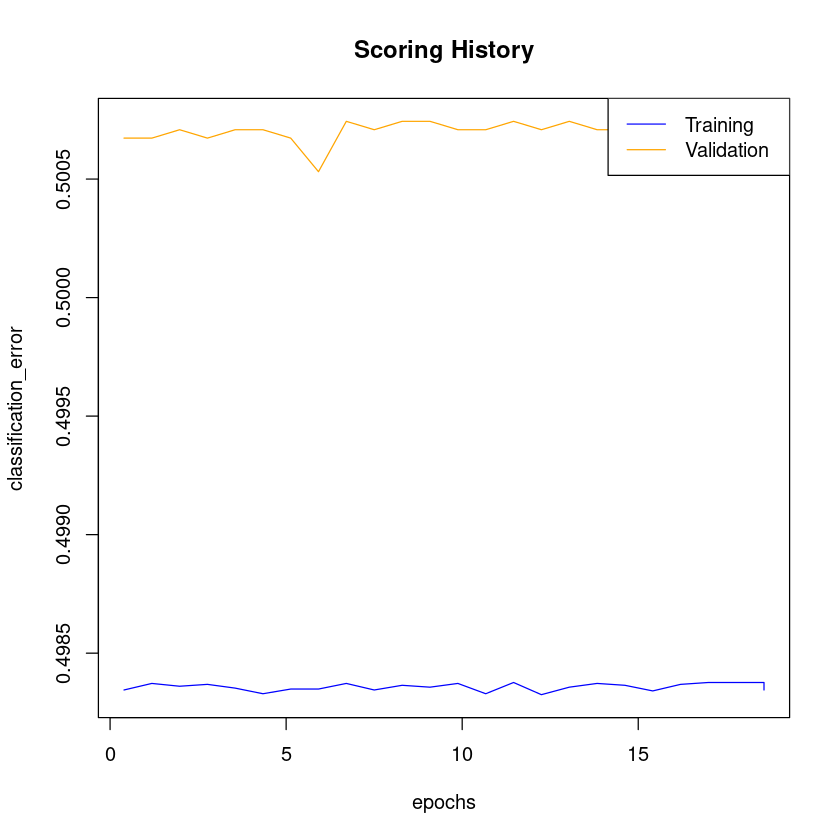

Warning message in use.package("data.table"):
“data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups.”


  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
“data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups.”


  |======================================================================| 100%
  |======================================================================| 100%


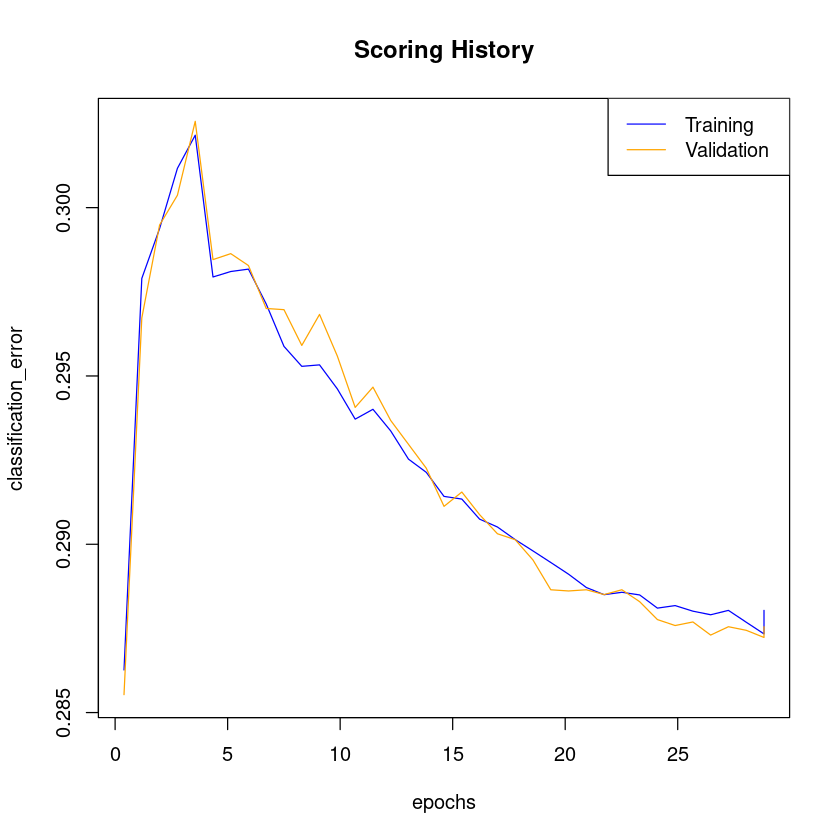

Warning message in use.package("data.table"):
“data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups.”


  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
“data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups.”


  |======================================================================| 100%
  |======================================================================| 100%


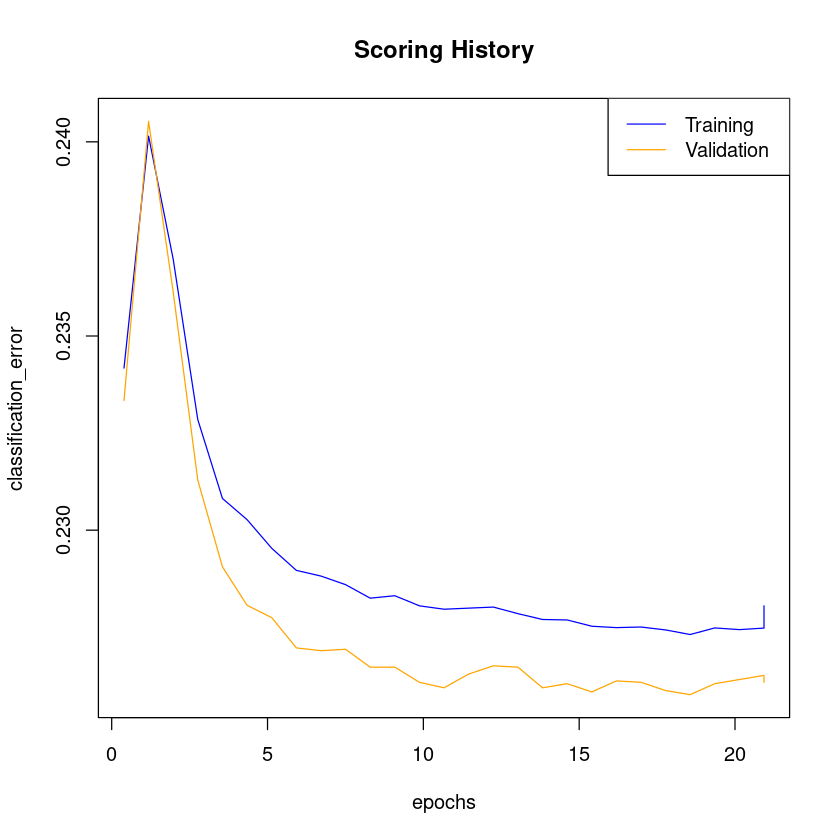

Warning message in use.package("data.table"):
“data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups.”


  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
“data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups.”


  |======================================================================| 100%
  |======================================================================| 100%


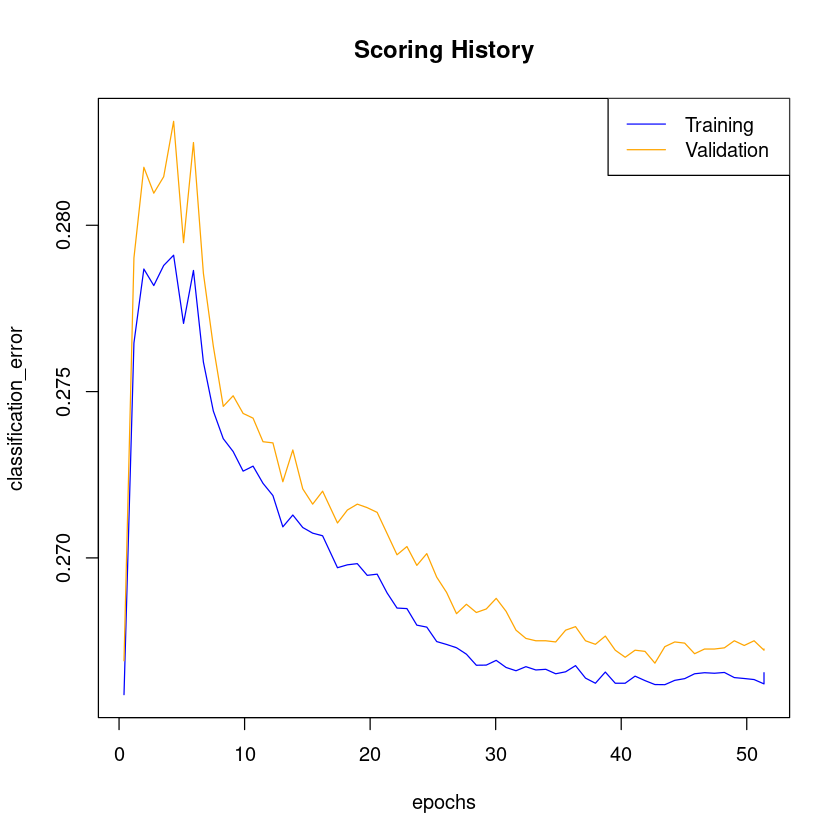

Warning message in use.package("data.table"):
“data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups.”


  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
“data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups.”


  |======================================================================| 100%
  |======================================================================| 100%


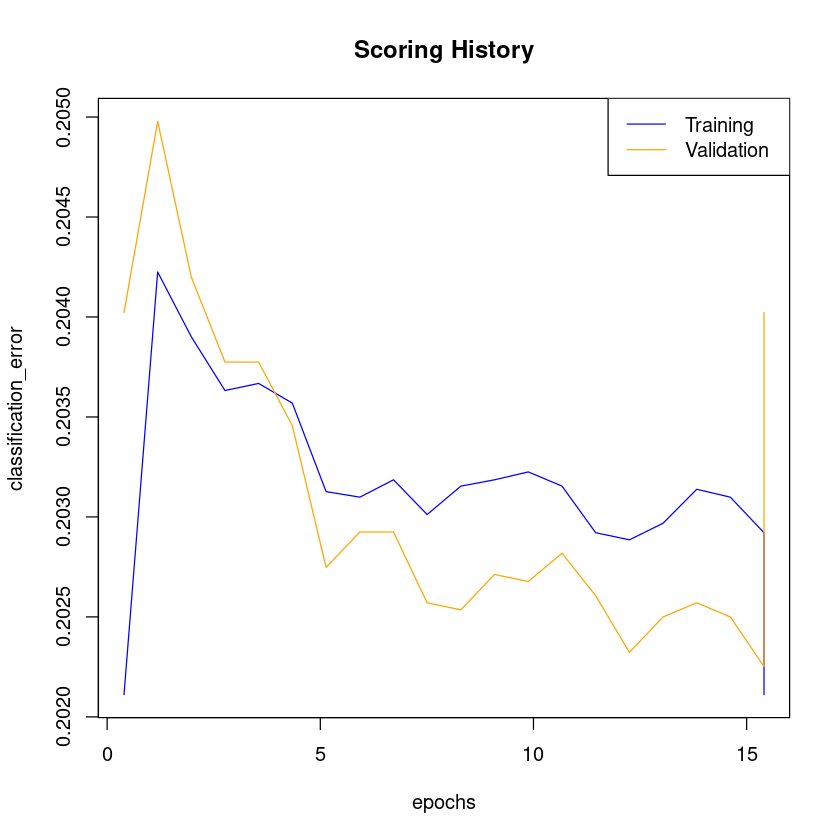

Warning message in use.package("data.table"):
“data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups.”


  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
“data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups.”


  |======================================================================| 100%
  |======================================================================| 100%


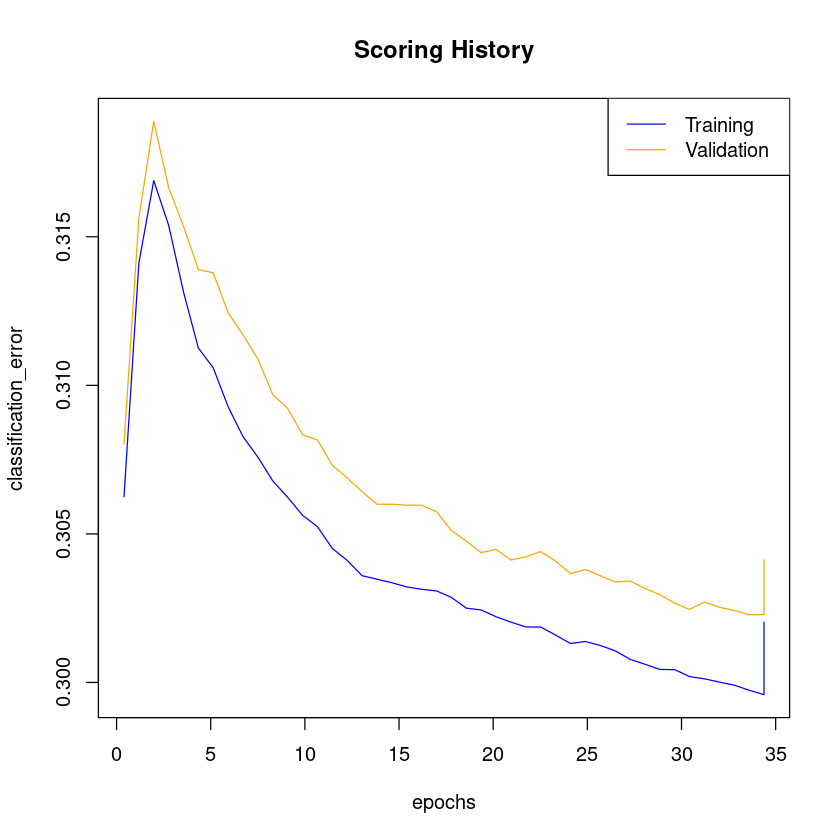

Warning message in use.package("data.table"):
“data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups.”


  |======================================================================| 100%
  |======================================================================| 100%


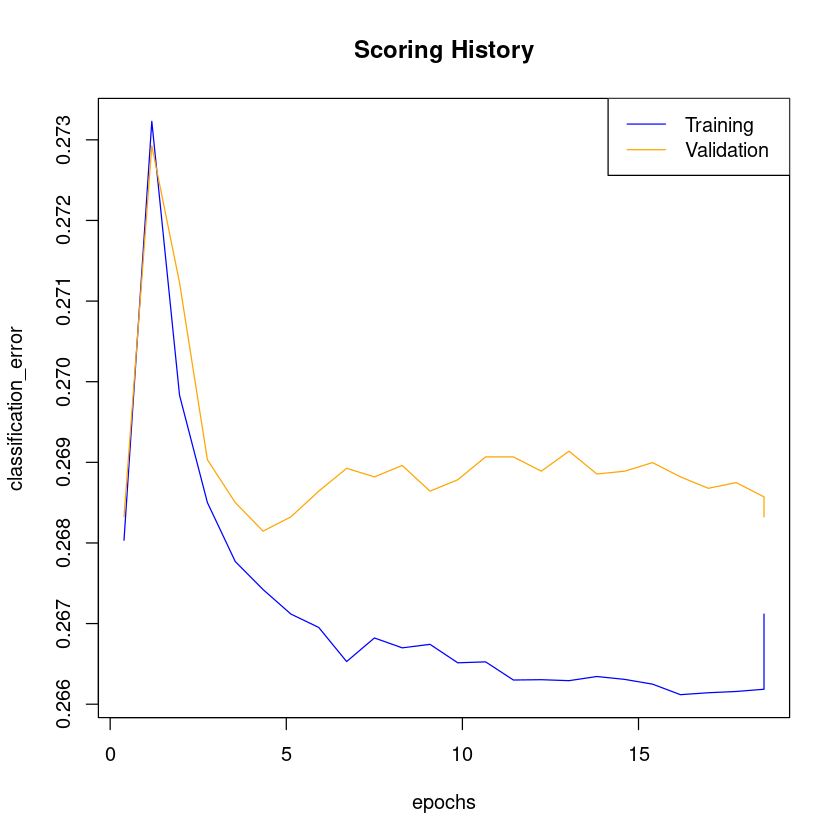

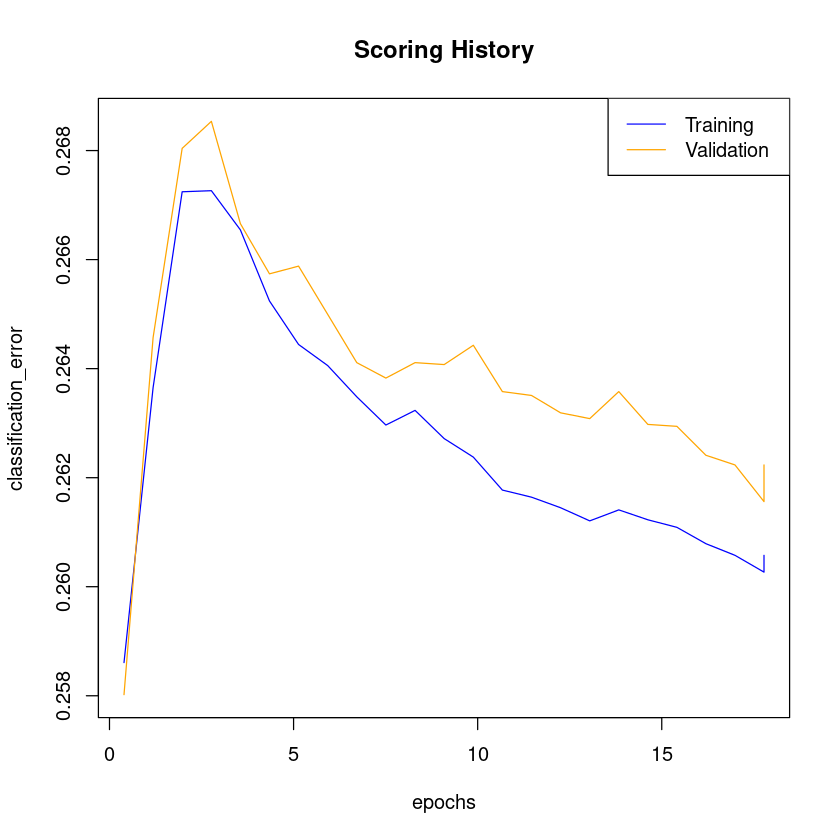

In [11]:
for (i in (1:length(output_set))) {
    
    train <- train_dfset[[i]]
    OUTPUT_FIELD <- colnames(train[,ncol(train),FALSE])
    test <- test_dfset[[i]]
   

    deep<-N_DEEP_TrainClassifier(train=train,
                                   fieldNameOutput=OUTPUT_FIELD,
                                   hidden=DEEP_HIDDEN,
                                   stopping_rounds=DEEP_STOPPING,
                                   stopping_tolerance = DEEP_TOLERANCE,
                                   activation=DEEP_ACTIVATION)
        
    plot(deep,metric="classification_error")
    
    test_expected<-test[,OUTPUT_FIELD]

    #Creates the h2o test dataset
    test[OUTPUT_FIELD] <- lapply(test[OUTPUT_FIELD] , factor) #Output class has to be a R "factor"
    test_h2o <- as.h2o(test, destination_frame = "testdata")

    pred <- h2o::h2o.predict(deep, test_h2o)

    #test_predicted<-as.vector(pred$p1)  #Returns the probabilities of class 1
    #predicted_list[[i]] = test_predicted
    
    perf <- pred$predict
    perf_pro <- pred$p1
    predicted_list[[i]] = perf
    prob_list[[i]] = perf_pro
}

$TP
[1] 9999

$FN
[1] 6275

$TN
[1] 67799

$FP
[1] 36515

$NPV
[1] 0.9153

$FPR
[1] 0.35

$TPR
[1] 0.6144

$TNR
[1] 0.65

$FNR
[1] 0.3856

$threatScore
[1] 0.1894

$balancedacc
[1] 0.6322

$threshold
[1] 0.37

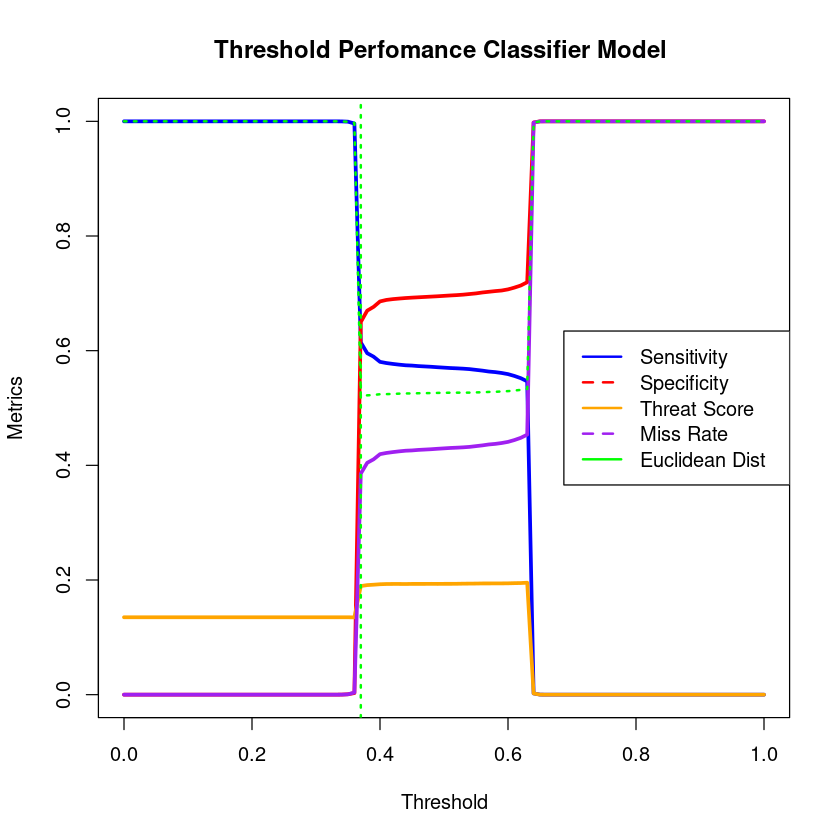

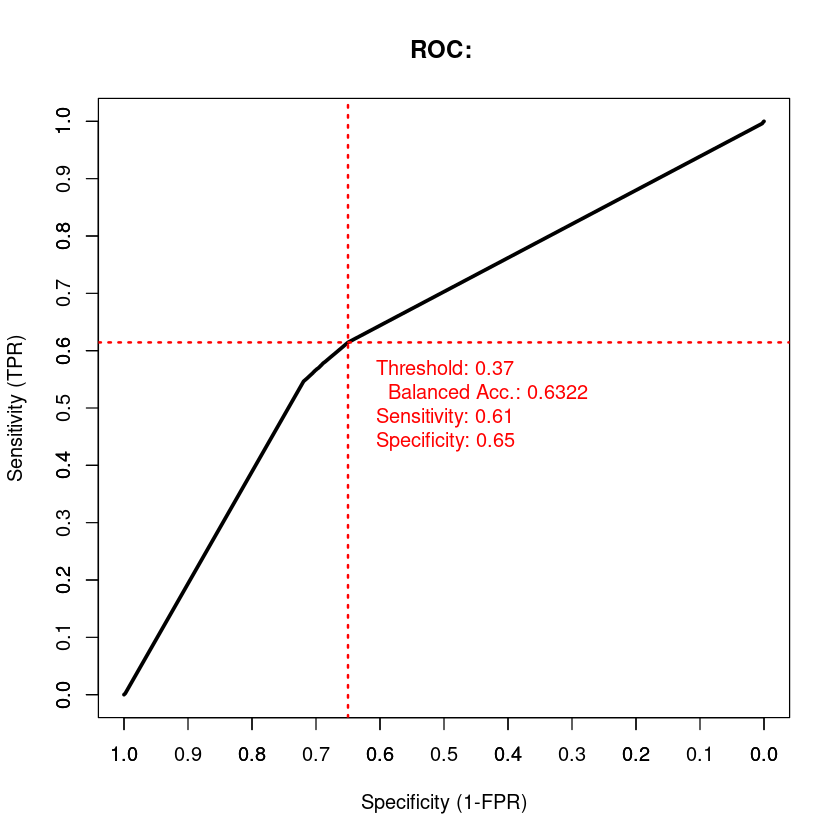

$TP
[1] 8158

$FN
[1] 2647

$TN
[1] 73189

$FP
[1] 36594

$NPV
[1] 0.9651

$FPR
[1] 0.3333

$TPR
[1] 0.755

$TNR
[1] 0.6667

$FNR
[1] 0.245

$threatScore
[1] 0.1721

$balancedacc
[1] 0.7108

$threshold
[1] 0.28

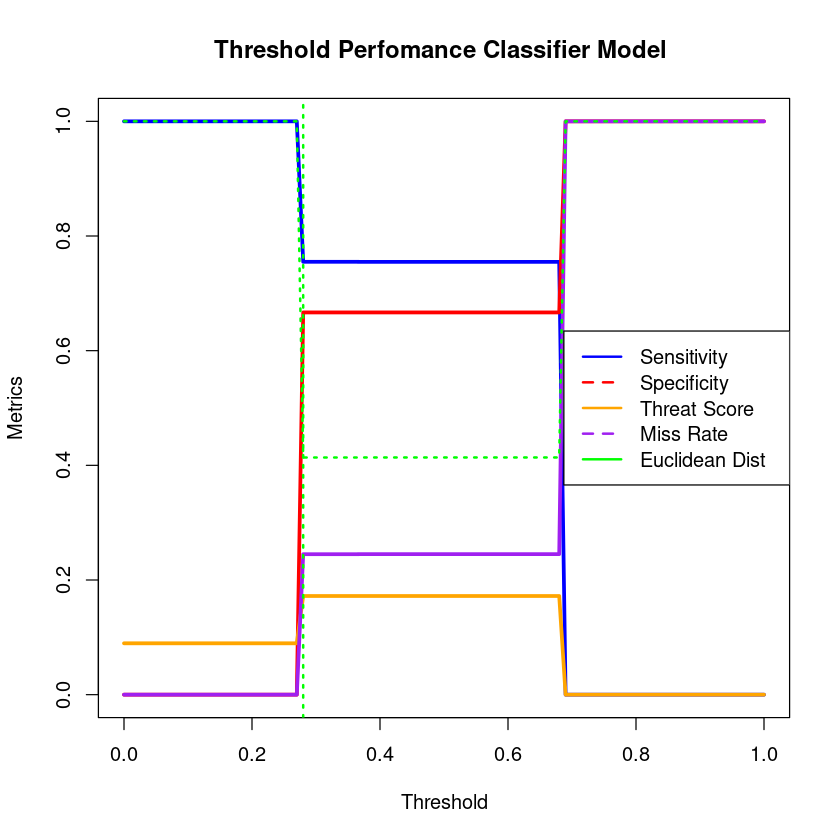

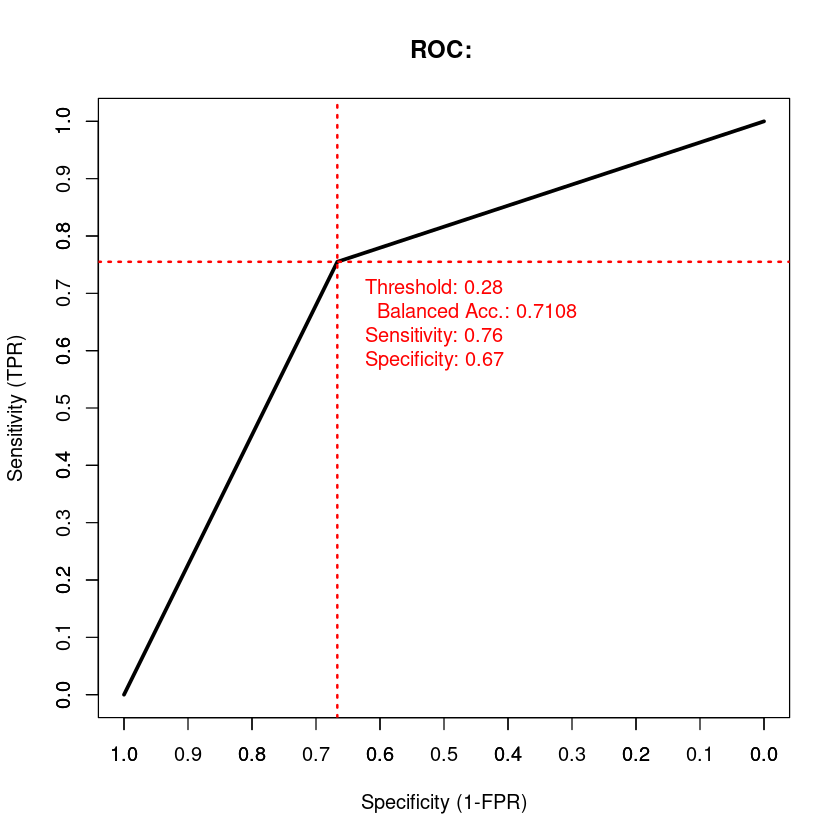

$TP
[1] 7025

$FN
[1] 2375

$TN
[1] 87867

$FP
[1] 23321

$NPV
[1] 0.9737

$FPR
[1] 0.2097

$TPR
[1] 0.7473

$TNR
[1] 0.7903

$FNR
[1] 0.2527

$threatScore
[1] 0.2147

$balancedacc
[1] 0.7688

$threshold
[1] 0.79

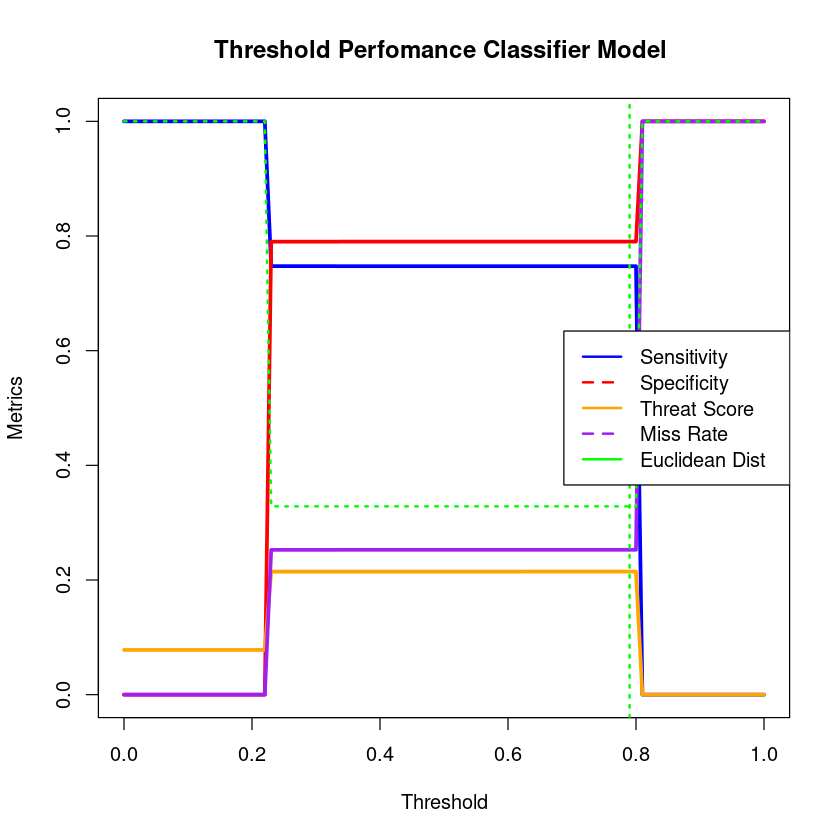

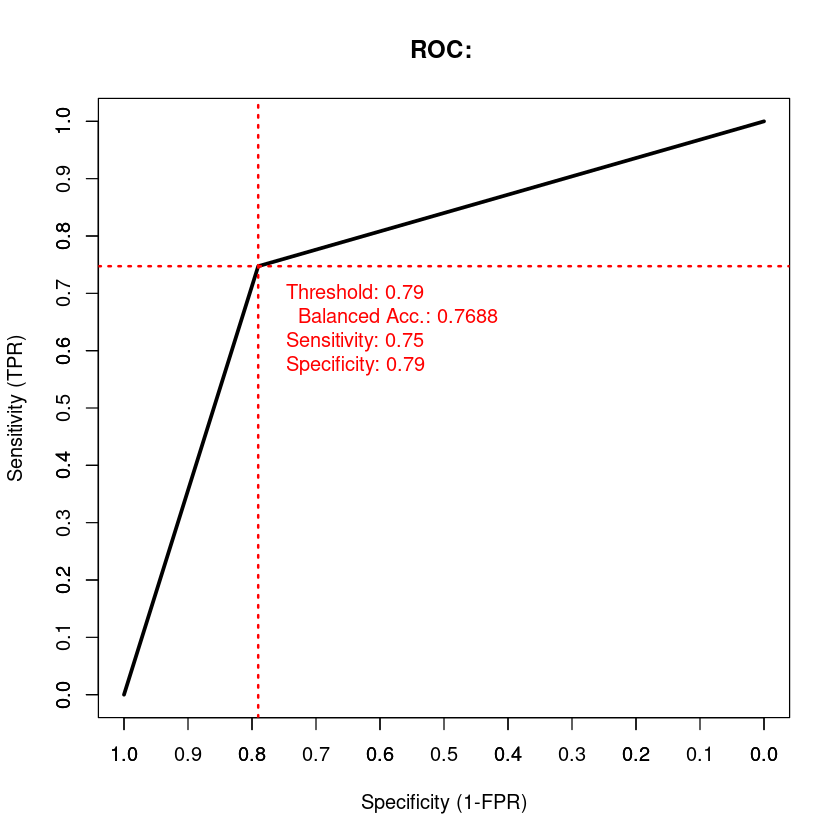

$TP
[1] 3198

$FN
[1] 1234

$TN
[1] 85920

$FP
[1] 30236

$NPV
[1] 0.9858

$FPR
[1] 0.2603

$TPR
[1] 0.7216

$TNR
[1] 0.7397

$FNR
[1] 0.2784

$threatScore
[1] 0.0922

$balancedacc
[1] 0.7306

$threshold
[1] 0.25

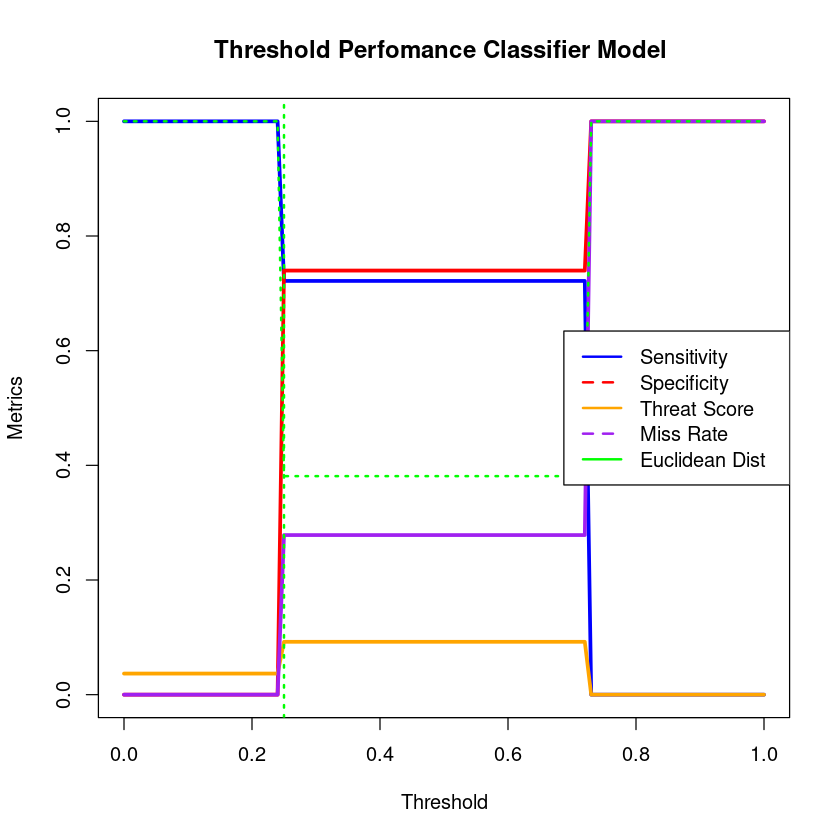

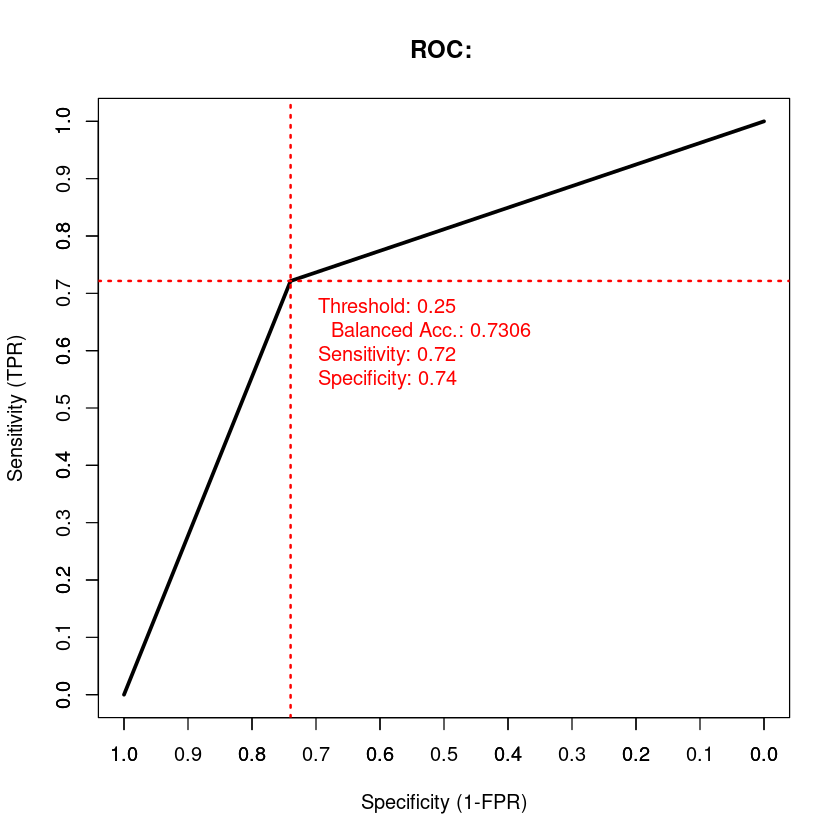

$TP
[1] 5407

$FN
[1] 1431

$TN
[1] 90542

$FP
[1] 23208

$NPV
[1] 0.9844

$FPR
[1] 0.204

$TPR
[1] 0.7907

$TNR
[1] 0.796

$FNR
[1] 0.2093

$threatScore
[1] 0.18

$balancedacc
[1] 0.7934

$threshold
[1] 0.65

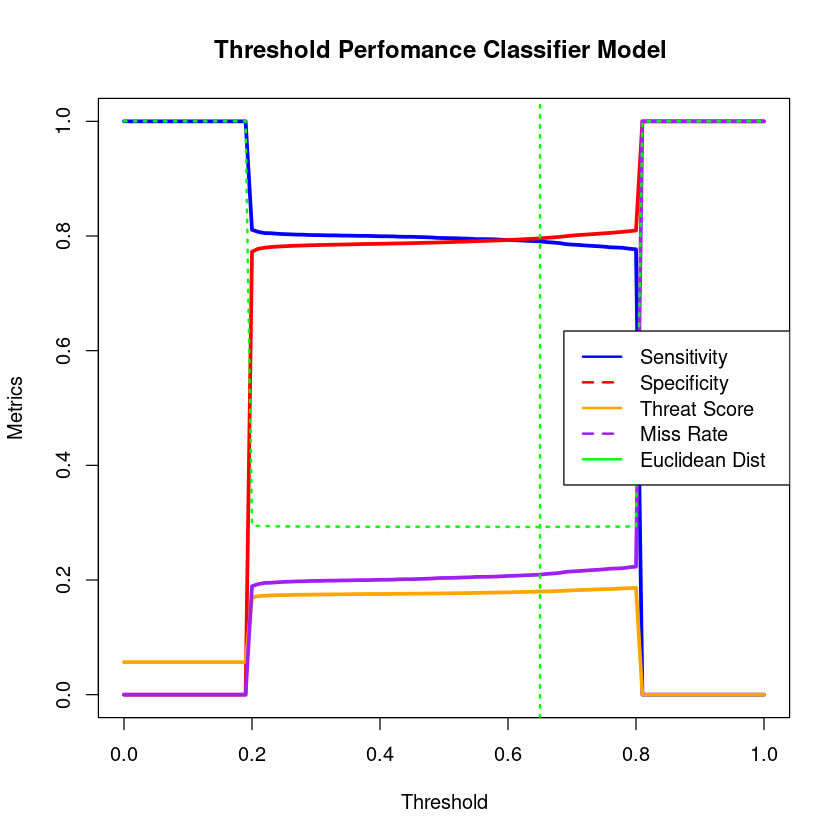

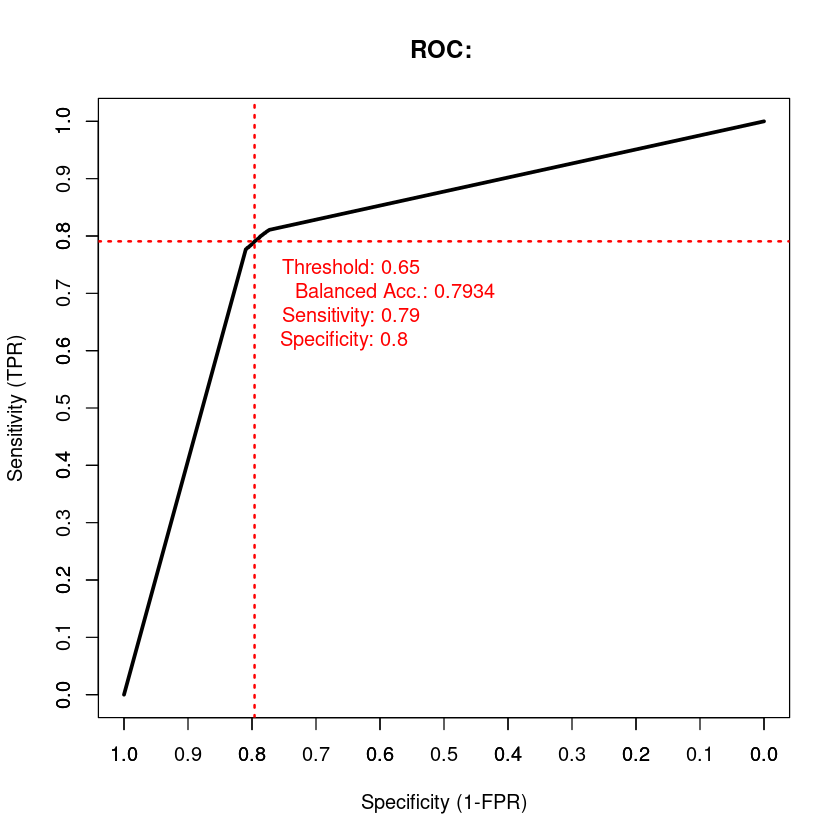

$TP
[1] 7978

$FN
[1] 3008

$TN
[1] 72924

$FP
[1] 36678

$NPV
[1] 0.9604

$FPR
[1] 0.3346

$TPR
[1] 0.7262

$TNR
[1] 0.6654

$FNR
[1] 0.2738

$threatScore
[1] 0.1674

$balancedacc
[1] 0.6958

$threshold
[1] 0.61

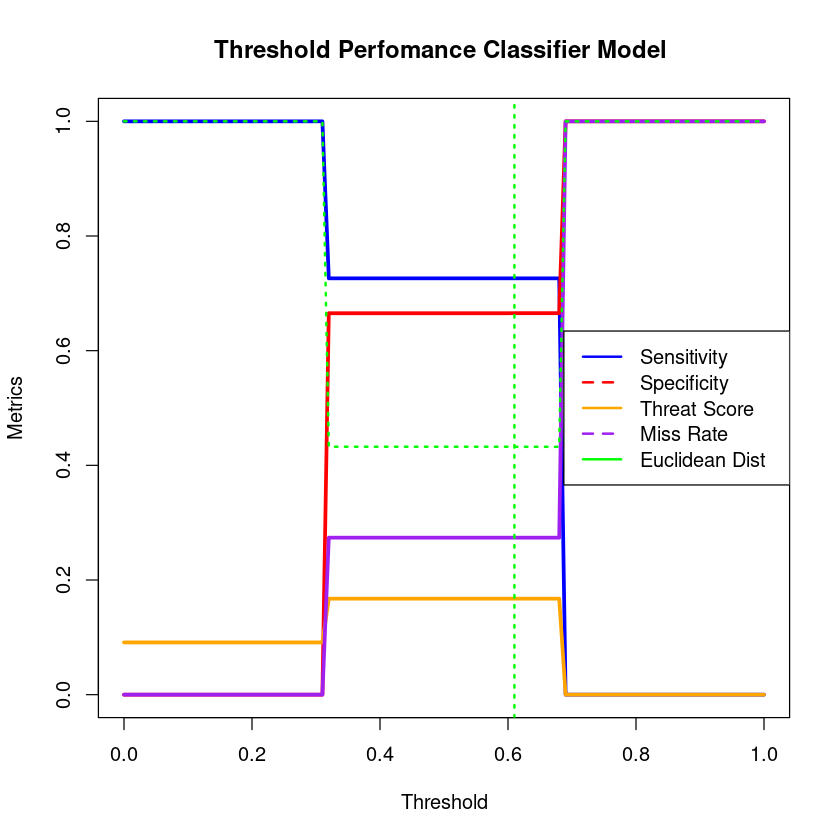

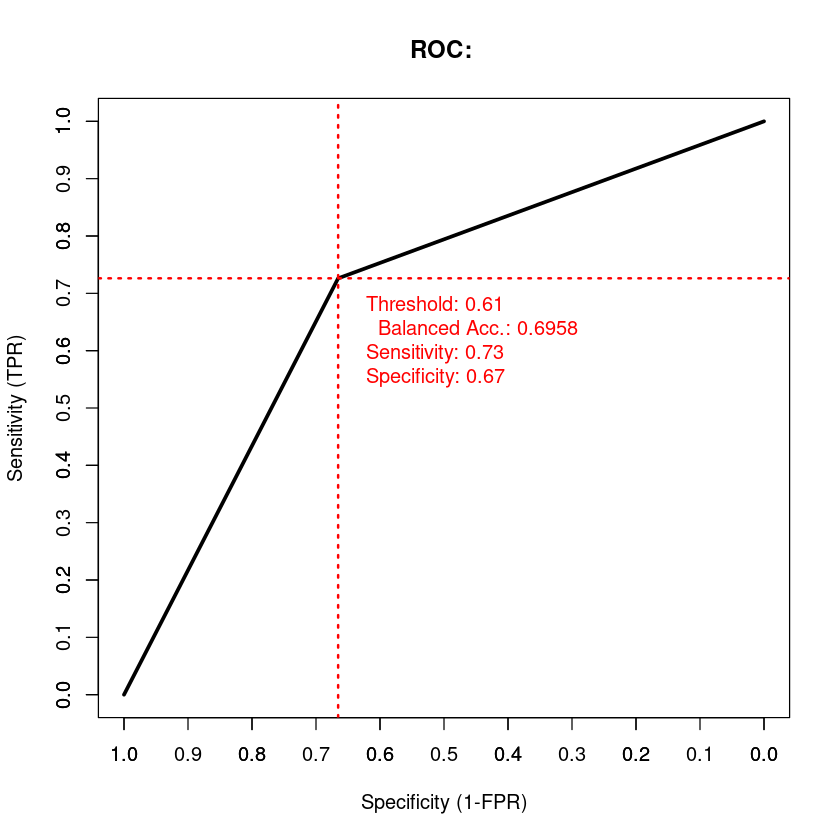

$TP
[1] 26843

$FN
[1] 10322

$TN
[1] 61776

$FP
[1] 21647

$NPV
[1] 0.8568

$FPR
[1] 0.2595

$TPR
[1] 0.7223

$TNR
[1] 0.7405

$FNR
[1] 0.2777

$threatScore
[1] 0.4564

$balancedacc
[1] 0.7314

$threshold
[1] 0.25

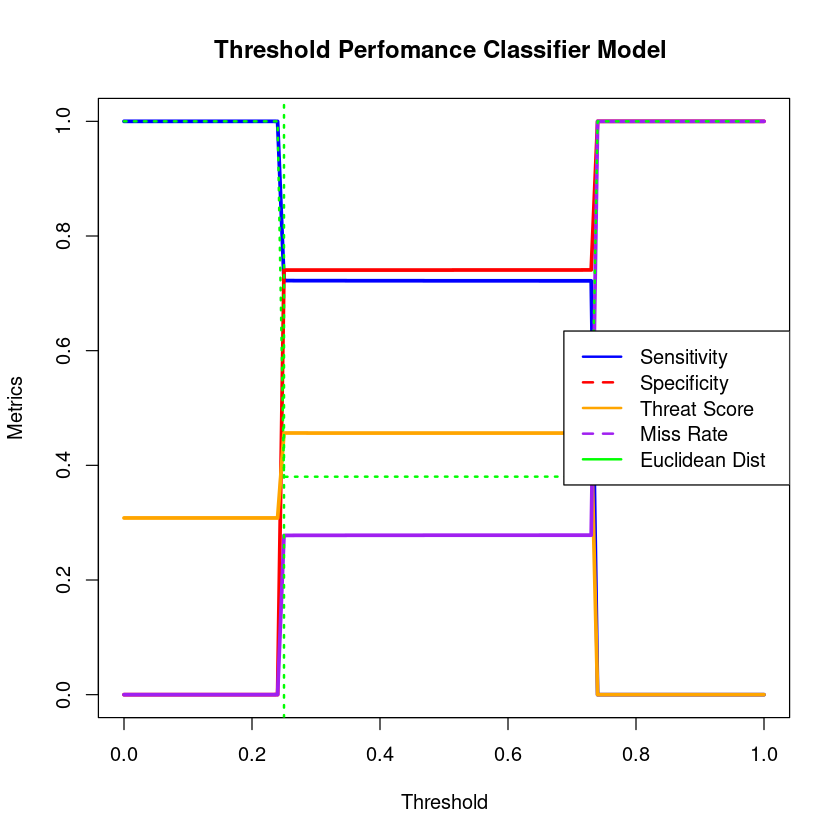

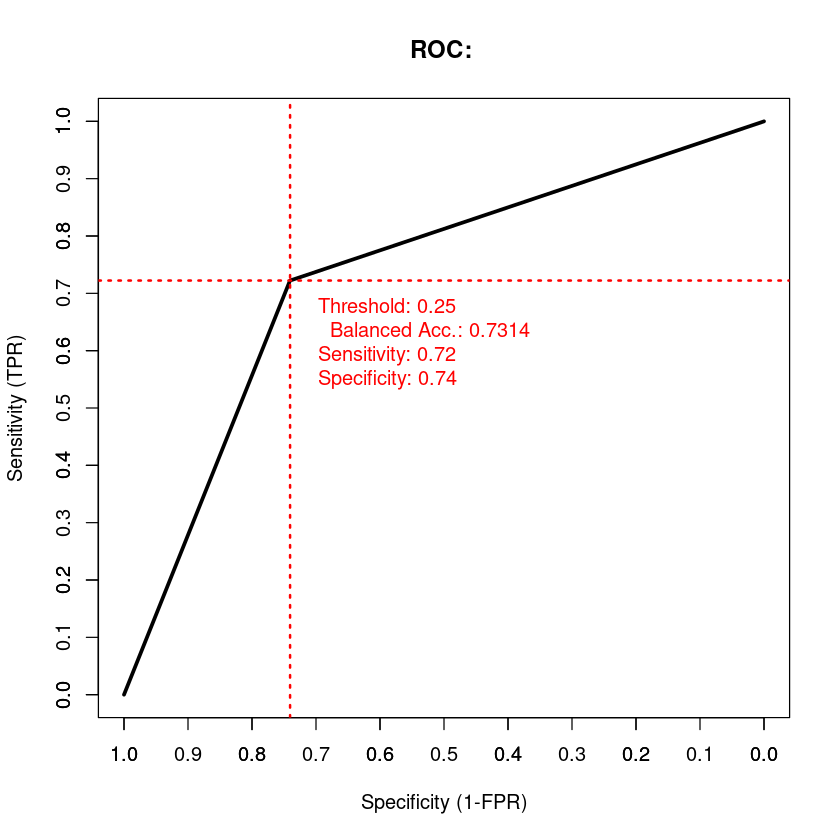

$TP
[1] 11530

$FN
[1] 4072

$TN
[1] 77475

$FP
[1] 27511

$NPV
[1] 0.9501

$FPR
[1] 0.262

$TPR
[1] 0.739

$TNR
[1] 0.738

$FNR
[1] 0.261

$threatScore
[1] 0.2674

$balancedacc
[1] 0.7385

$threshold
[1] 0.52

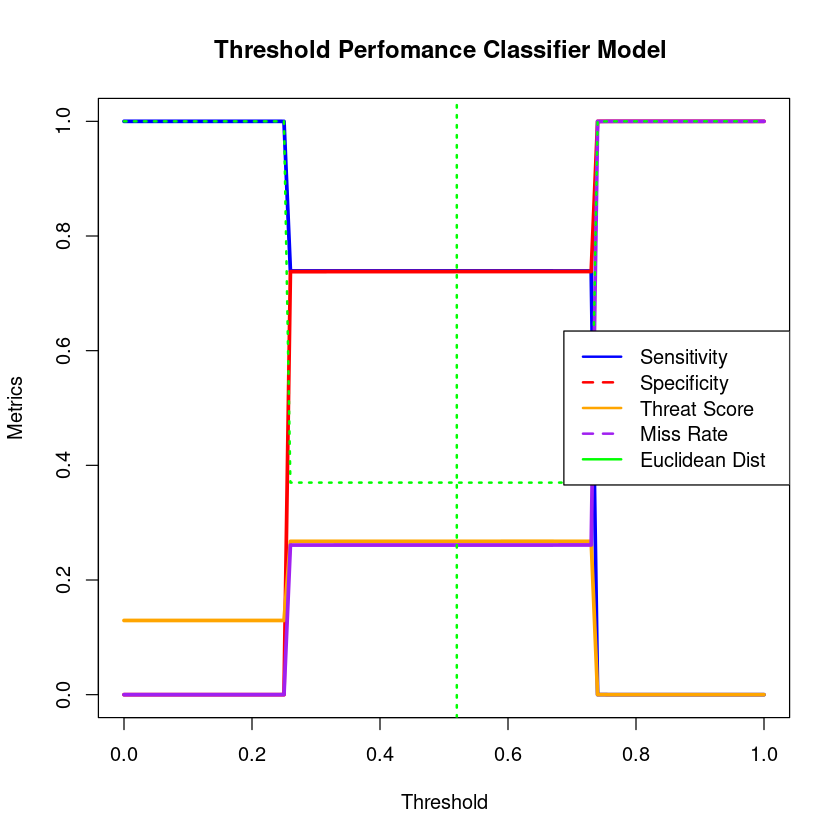

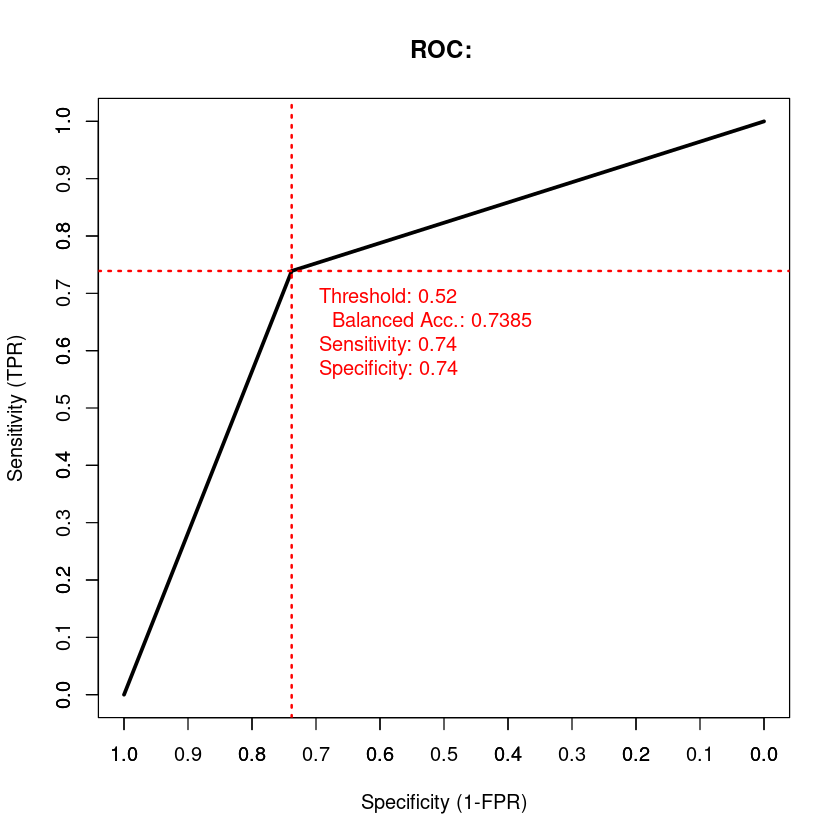

In [12]:
for (i in (1:length(output_set))) {
    
     NdetermineThreshold(test_expected=as.numeric(test_output[,i]),
                                test_predicted=as.numeric(as.vector(prob_list[[i]])))
    }

In [13]:
prob_df = data.frame(matrix(0, nrow = 120588, ncol = 8))
colnames(predict_df) <- output_set
colnames(prob_df) <- output_set
for (i in (1:length(output_set))) {
    prob_df[i] = as.vector(prob_list[[i]])
    }
head(prob_df)
head(test_output)

,ASTHMA3,CHCSCNCR,CHCCOPD2,CHCKDNY2,CVDCRHD4,CHCOCNCR,HAVARTH4,DIABETE4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.6358822,0.2757394,0.8093218,0.7283092,0.1973041,0.6816287,0.7329904,0.7380852
2,0.3694146,0.6814898,0.2277027,0.2446471,0.1973041,0.6816287,0.7329904,0.2582808
3,0.6357312,0.6814898,0.8093218,0.7283092,0.8096406,0.6816287,0.7329904,0.7380852
4,0.3694146,0.6814898,0.2277027,0.2446471,0.1973041,0.6816287,0.7329904,0.2582808
5,0.3694146,0.6814898,0.2277027,0.2446471,0.1973041,0.3170315,0.2474383,0.2582808
6,0.3694144,0.6814898,0.2277027,0.7283092,0.8087252,0.6816287,0.7329904,0.7380852


,ASTHMA3,CHCSCNCR,CHCCOPD2,CHCKDNY2,CVDCRHD4,CHCOCNCR,HAVARTH4,DIABETE4
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
8,0,0,0,0,0,1,1,1
13,0,0,0,0,0,0,1,0
15,0,0,0,0,0,1,1,0
25,1,0,0,0,0,0,0,0
26,0,1,0,0,0,0,1,0
27,0,0,0,0,0,0,0,0
